# Exploratory Data Analysis

The data has five variables from log informations and two geologic constraining variables for nine wells. Let's dig deep into othese information and see what they have to say about the data.

## 1.0 Import Libraries

In [1]:
print ('Loading libraries ...')

import os

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import config
import utils

Loading libraries ...


/Users/obikacd/opt/miniconda3/envs/facies_classes/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 2.0 Get Our Data

The dataset is loaded from a csv stored in the root folder.

In [2]:
dataset = 'datasets/facies_data.csv'
data = pd.read_csv(dataset)
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


## 3.0 Data Check

How is the shape of the dataset? What other information can we get from the data?

In [3]:
data.shape

(3232, 11)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     3232 non-null   int64  
 1   Formation  3232 non-null   object 
 2   Well Name  3232 non-null   object 
 3   Depth      3232 non-null   float64
 4   GR         3232 non-null   float64
 5   ILD_log10  3232 non-null   float64
 6   DeltaPHI   3232 non-null   float64
 7   PHIND      3232 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       3232 non-null   int64  
 10  RELPOS     3232 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 277.9+ KB


The data has 3232 rows and 11 columns, there are no null values. eEcept for the 'Well Name' and 'Formation' columns that are object (categorical) data types, the other columns are numerical.

Are there duplicates in the dataset? Let's check that out.

In [5]:
print(data.duplicated().sum())

1


In [6]:
data.loc[data.duplicated(keep=False), :]

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
301,8,B5 LM,SHRIMPLIN,2944.0,234.8,0.515,4.7,11.41,4.8,2,0.4
302,8,B5 LM,SHRIMPLIN,2944.0,234.8,0.515,4.7,11.41,4.8,2,0.4


In [7]:
data = data.drop_duplicates().reset_index(drop=True)

We identified and confirmed that there is one duplicate in the dataset. Removing it reduced our dataset to 3231 rows.

What are our input variables and our target variable?

In [8]:
data_columns = data.columns
input_variables = data.drop('Facies', axis=1).columns
target_variable = data.drop(input_variables, axis=1).columns
print(list(input_variables))
print(list(target_variable))

['Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
['Facies']


Let's see how many classes we have in our target variable and visualize the distribution.

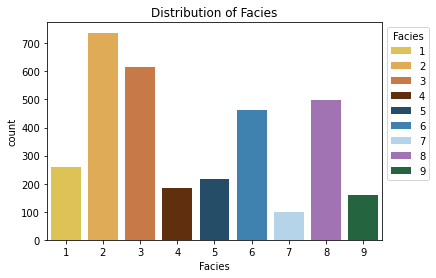

In [9]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100})
sns.countplot(x='Facies', hue='Facies', data=data, palette = config.FACIES_COLORS, dodge=False)
plt.title('Distribution of Facies')
plt.legend(title = 'Facies', loc = 2, bbox_to_anchor=(1, 1))
plt.show()

We find a noticeable imbalance in the dataset.

How many unique values do we have in the 'Formation' and the "Well Name" column? Are the unique values in the formation column found in all the wells? 

In [10]:
formations = data.Formation.unique()
print(formations)
wells = data['Well Name'].unique()
print(wells)
print(f'There are {len(formations)} formations')
print(f'There are {len(wells)} wells')

['A1 SH' 'A1 LM' 'B1 SH' 'B1 LM' 'B2 SH' 'B2 LM' 'B3 SH' 'B3 LM' 'B4 SH'
 'B4 LM' 'B5 SH' 'B5 LM' 'C SH' 'C LM']
['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
There are 14 formations
There are 8 wells


In [11]:
wells_with_complete_formation = 0
wells_with_incomplete_formation = 0
formations = list(formations)
formations.sort()
formations_list = []
formations_set = set()
for well in wells:
    formation_well = data.Formation[data['Well Name'] == well].unique()
    formation_well = list(formation_well)
    formation_well.sort
    if formation_well not in formations_list:
        formations_list.append(formation_well)
    if formations == formation_well:
        wells_with_complete_formation += 1
    else:
        wells_with_incomplete_formation += 1
print(f'{wells_with_complete_formation} wells has no missing formations \n{wells_with_incomplete_formation} wells has missing formations')
print(len(formations_list))   

0 wells has no missing formations 
8 wells has missing formations
5


The formations in the dataset are not common to all eight wells. Well Name column contains unique identifier values. We will test these columns for correlation with the target variable to decide if they will be included in the features for model training.

## 4.0 Data Analysis

We will start the analysis with only the numerical columns of the dataset

In [12]:
eda_data = data.drop(['Formation', 'Well Name'], axis = 1)

In [13]:
eda_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000
mean,4.420922,2875.803466,66.083567,0.642759,3.559289,13.483855,3.724681,1.498298,0.520325
std,2.503839,131.021059,30.716527,0.241872,5.229719,7.700085,0.896091,0.500074,0.286829
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.914500,0.492500,1.162500,8.343500,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.700000,0.624591,3.500000,12.150000,3.551000,1.000000,0.526000
75%,6.000000,2980.000000,79.625000,0.812823,6.436000,16.457500,4.300000,2.000000,0.767500
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


We can gather some information about the dataset from the table above. We have the mean and the std for each column, from these we can infer the skewness of the data or otherwise. Let's use some frequency plots to understand these numerical data a little bit more.

In [14]:
eda_data_analysis = utils.UniAnalysis(eda_data)

count    3231.000000
mean       66.083567
std        30.716527
min        13.250000
25%        46.914500
50%        65.700000
75%        79.625000
max       361.150000
Name: GR, dtype: float64
******************************************************************************************************************************************************


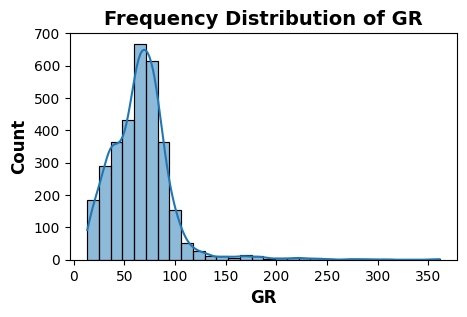

******************************************************************************************************************************************************


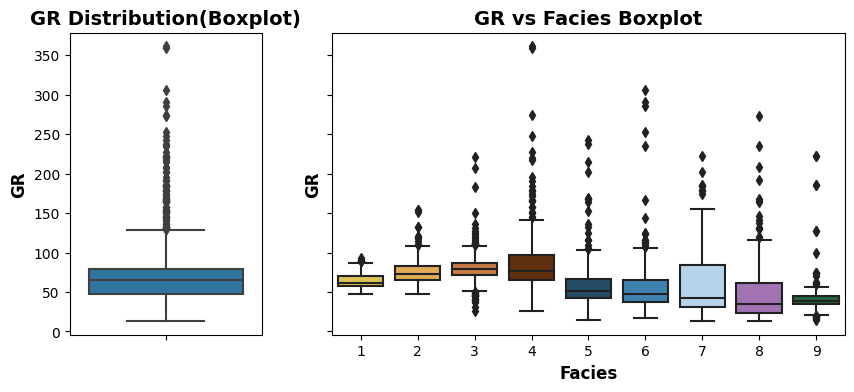

In [15]:
#GR analysis
print(eda_data_analysis.describe_feature('GR'))
print('*'*150)
eda_data_analysis.create_histplot('GR', 30)
print('*'*150)
eda_data_analysis.create_boxplot('GR', 'Facies')

-   The values in the 'GR' column is skewed to the right
-   The values corresponding to the facies classes have considerable overlaps
-   There are outliers in the individual facies classes

count    3231.000000
mean        0.642759
std         0.241872
min        -0.025949
25%         0.492500
50%         0.624591
75%         0.812823
max         1.480000
Name: ILD_log10, dtype: float64
******************************************************************************************************************************************************


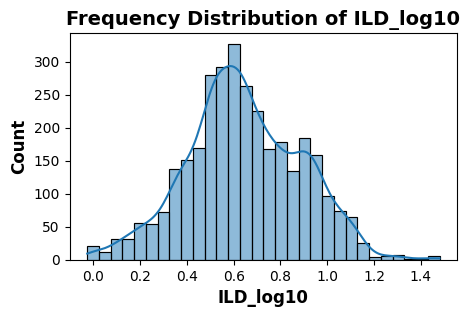

******************************************************************************************************************************************************


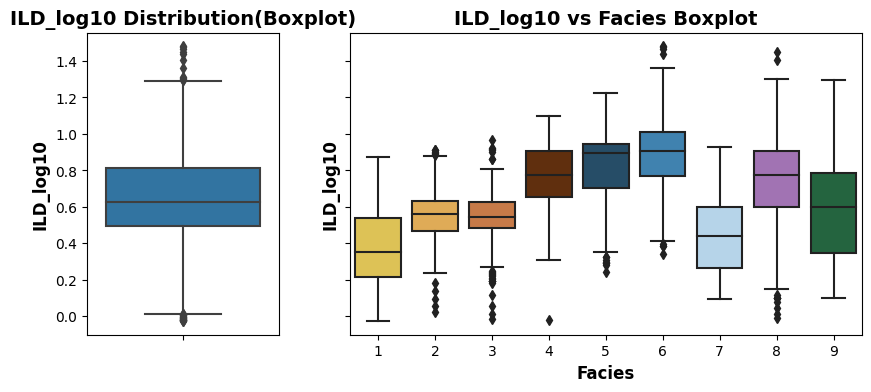

In [16]:
#ILD_log10 analysis
print(eda_data_analysis.describe_feature('ILD_log10'))
print('*'*150)
eda_data_analysis.create_histplot('ILD_log10', 30)
print('*'*150)
eda_data_analysis.create_boxplot('ILD_log10', 'Facies')

-   The values in the 'IL_log10' column is minimally skewed to the right
-   There is no clear separation of the facies classes in this column
-   There are few facies classes with outliers

count    3231.000000
mean        3.559289
std         5.229719
min       -21.832000
25%         1.162500
50%         3.500000
75%         6.436000
max        18.600000
Name: DeltaPHI, dtype: float64
******************************************************************************************************************************************************


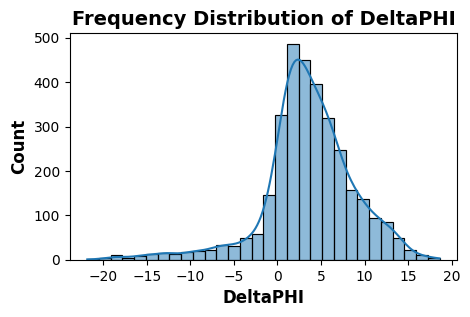

******************************************************************************************************************************************************


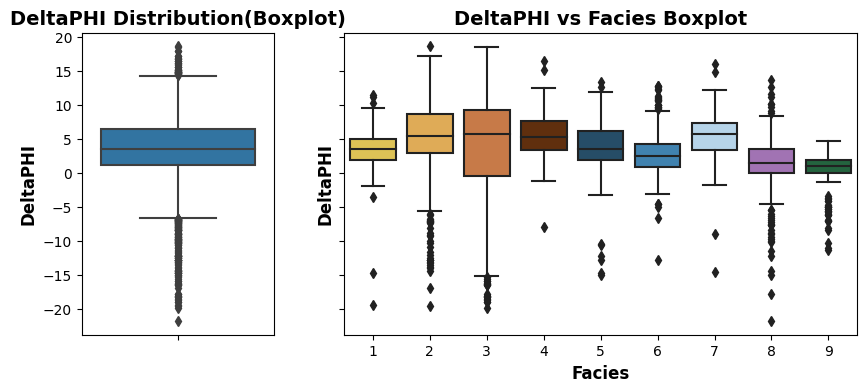

In [17]:
#DeltaPHI analysis
print(eda_data_analysis.describe_feature('DeltaPHI'))
print('*'*150)
eda_data_analysis.create_histplot('DeltaPHI', 30)
print('*'*150)
eda_data_analysis.create_boxplot('DeltaPHI', 'Facies')

-   The values in the 'DeltaPHI' column is skewed to the left
-   The vlaues corresponding to the facies classes have considerable overlaps
-   There are outliers in the individual facies classes

count    3231.000000
mean       13.483855
std         7.700085
min         0.550000
25%         8.343500
50%        12.150000
75%        16.457500
max        84.400000
Name: PHIND, dtype: float64
******************************************************************************************************************************************************


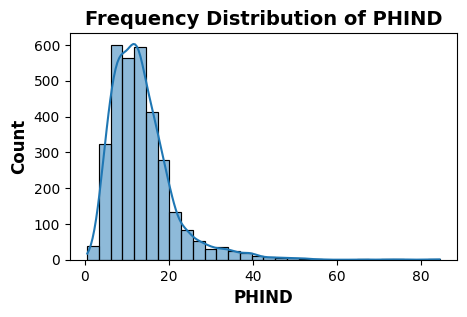

******************************************************************************************************************************************************


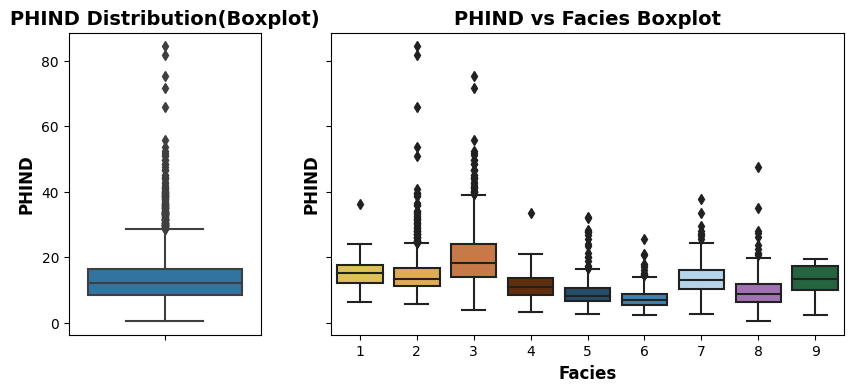

In [18]:
#PHIND analysis
print(eda_data_analysis.describe_feature('PHIND'))
print('*'*150)
eda_data_analysis.create_histplot('PHIND', 30)
print('*'*150)
eda_data_analysis.create_boxplot('PHIND', 'Facies')

-   The values in the 'PHIND' column is skewed to the right
-   The vlaues corresponding to the facies classes have considerable overlaps
-   There are outliers in the individual facies classes only on the upper end of the distribution

count    3231.000000
mean        3.724681
std         0.896091
min         0.200000
25%         3.100000
50%         3.551000
75%         4.300000
max         8.094000
Name: PE, dtype: float64
**************************************************


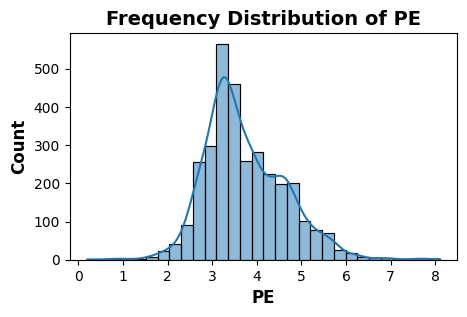

******************************************************************************************************************************************************


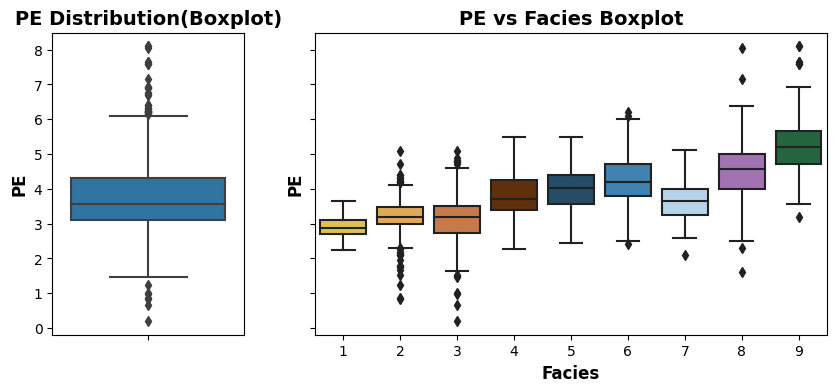

In [19]:
#PE analysis
print(eda_data_analysis.describe_feature('PE'))
print('*'*50)
eda_data_analysis.create_histplot('PE', 30)
print('*'*150)
eda_data_analysis.create_boxplot('PE', 'Facies')

-   The values in the 'PE' column is close to a normal distribution
-   The vlaues corresponding to the facies classes have considerable overlaps
-   There are just a few outliers in tsome of he individual facies classes

count    3231.000000
mean        1.498298
std         0.500074
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: NM_M, dtype: float64
******************************************************************************************************************************************************


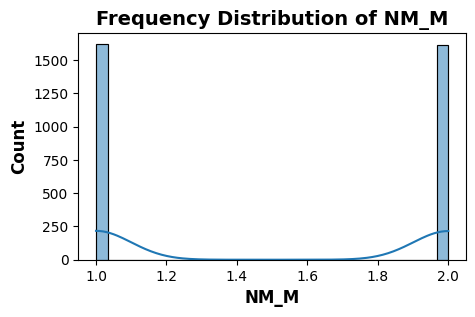

******************************************************************************************************************************************************


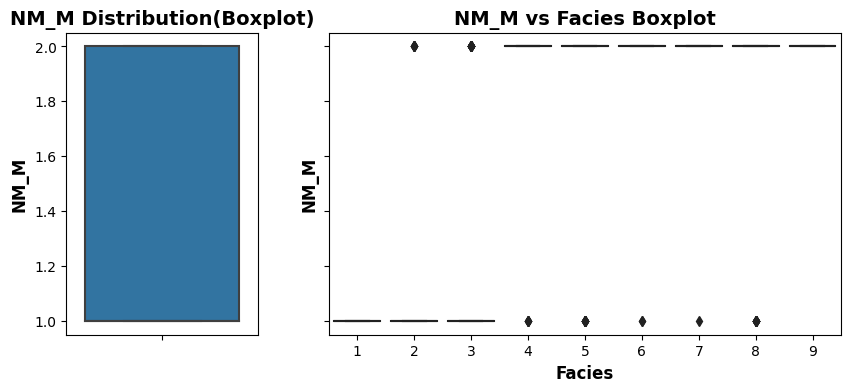

In [20]:
#NM_M analysis
print(eda_data_analysis.describe_feature('NM_M'))
print('*'*150)
eda_data_analysis.create_histplot('NM_M', 30)
print('*'*150)
eda_data_analysis.create_boxplot('NM_M', 'Facies')

-   The values in this column are spread between 1 and 2.
-   There is little information here to use for any analysis

count    3231.000000
mean        0.520325
std         0.286829
min         0.010000
25%         0.273000
50%         0.526000
75%         0.767500
max         1.000000
Name: RELPOS, dtype: float64
******************************************************************************************************************************************************


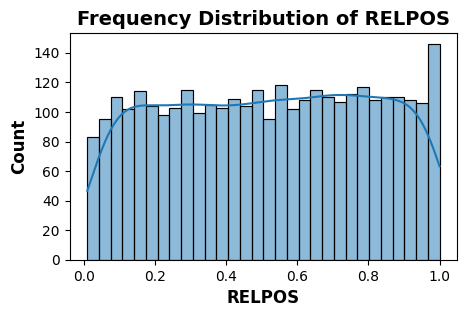

******************************************************************************************************************************************************


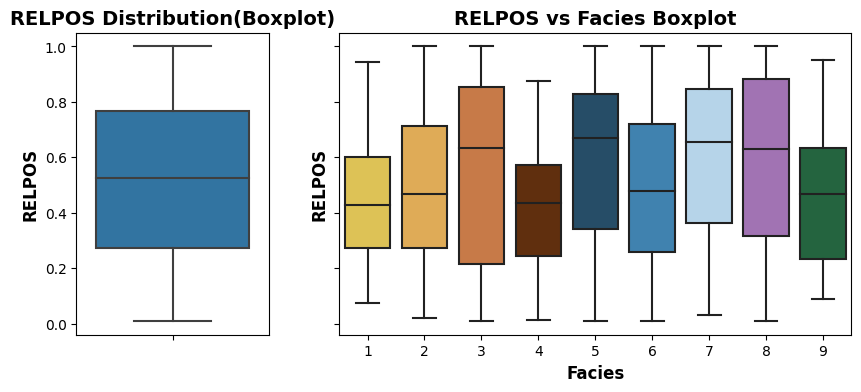

In [21]:
#RELPOS analysis
print(eda_data_analysis.describe_feature('RELPOS'))
print('*'*150)
eda_data_analysis.create_histplot('RELPOS', 30)
print('*'*150)
eda_data_analysis.create_boxplot('RELPOS', 'Facies')

-   There are overlaps of values corresponding to the invidual facies classes
-   There are no outliers

count    3231.000000
mean     2875.803466
std       131.021059
min      2573.500000
25%      2791.000000
50%      2893.500000
75%      2980.000000
max      3122.500000
Name: Depth, dtype: float64
******************************************************************************************************************************************************


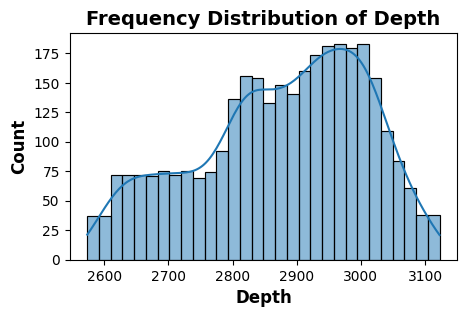

******************************************************************************************************************************************************


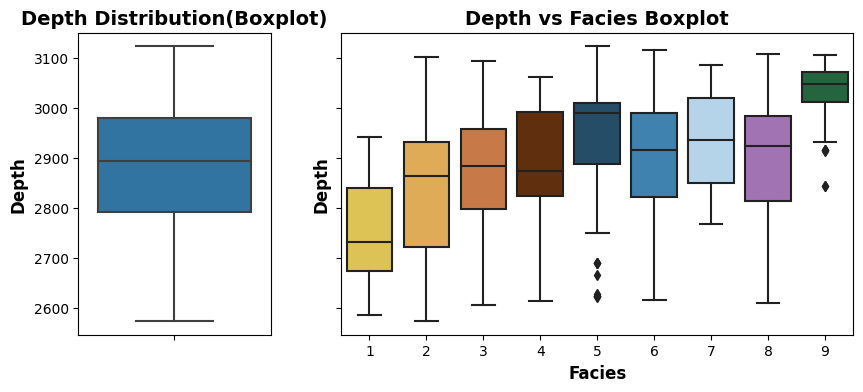

In [22]:
#Depth analysis
print(eda_data_analysis.describe_feature('Depth'))
print('*'*150)
eda_data_analysis.create_histplot('Depth', 30)
print('*'*150)
eda_data_analysis.create_boxplot('Depth', 'Facies')

-   There are overlaps of values corresponding to the invidual facies classes
-   Outliers in this column are quite few

### Correlation among numerical variables

Let's look into the correlation between these numerical variables. The goal here is to identify if the input variables are highly correlated which may lead to over fitting issues with the model. 
First, we look at the pairplot for the variables.

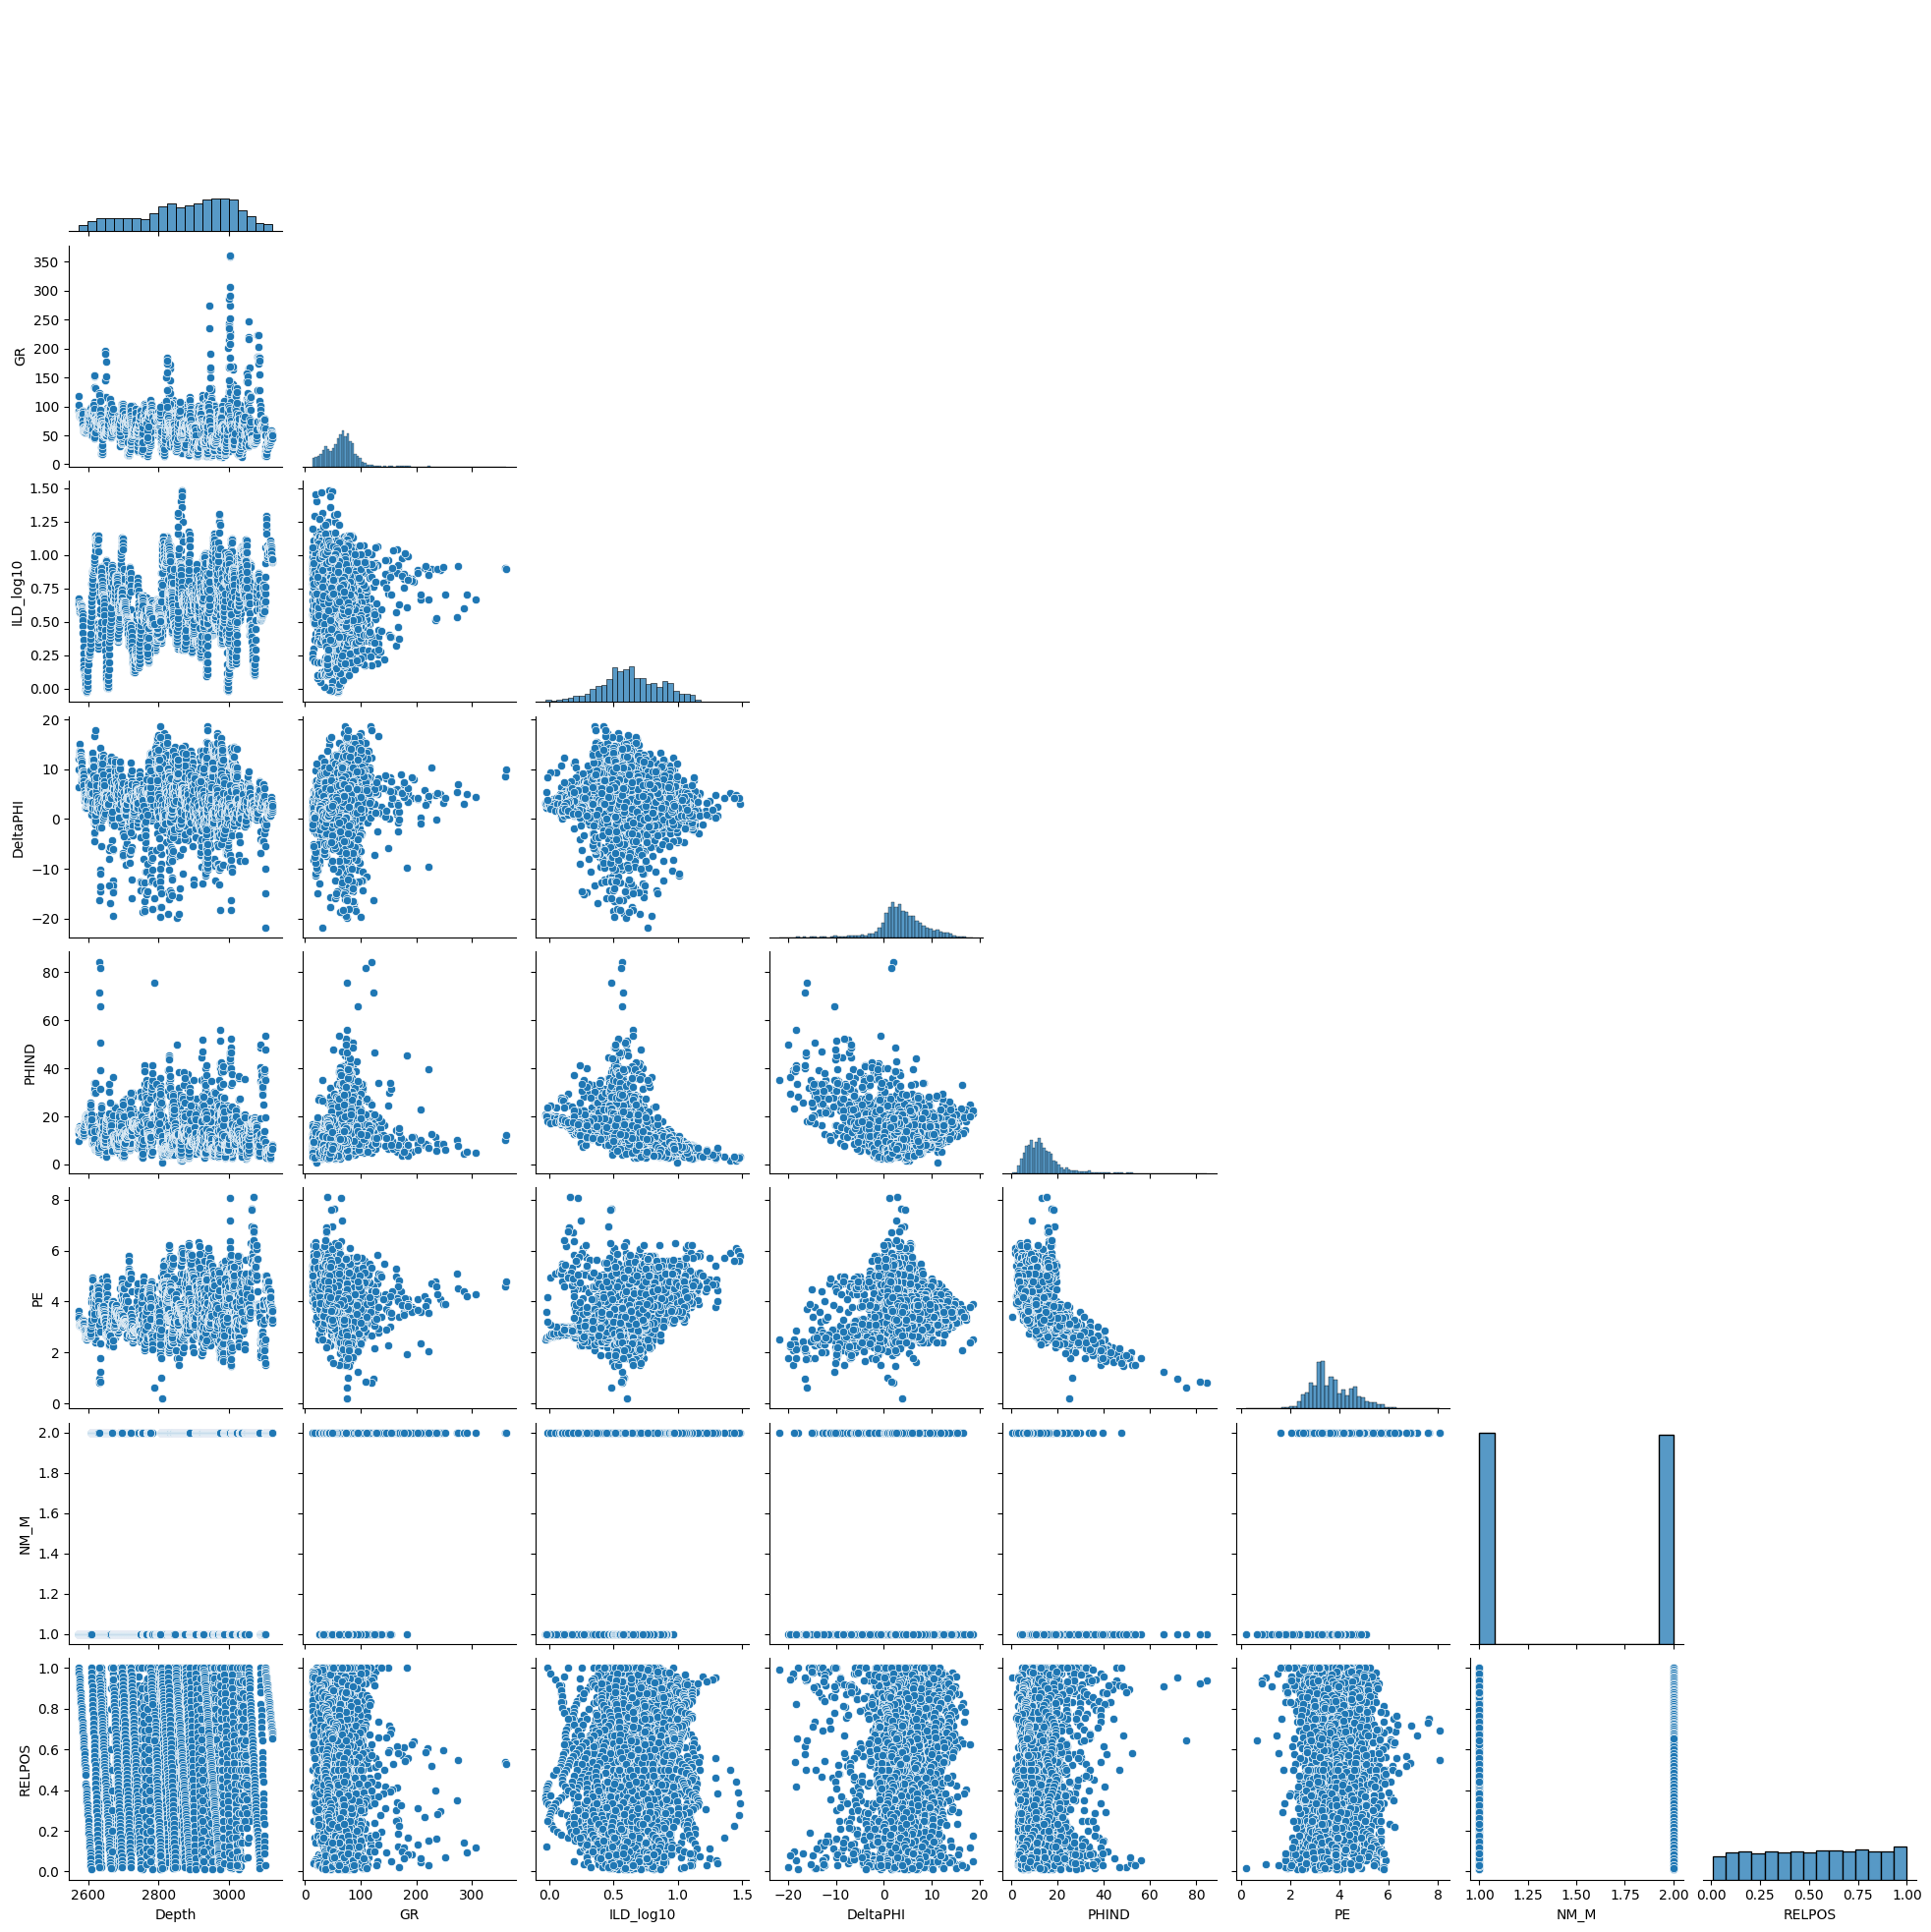

In [23]:
sns.pairplot(data=eda_data.drop(['Facies'],axis=1),corner=True)
plt.show()

There are some correlated variables from the plot. Since we don't have the knowledge to establish if there is any form of relationship between these variables, we will keep them in the dataset. Later on after training the model, we will use a feature importance bar plot to see if these correlated variables are in the top important features. Before then, we can view some of these correlations in a regplot for specific pairs of variables. We can also use the correlation matrix to further the correlations we have observed in the pairplot. 

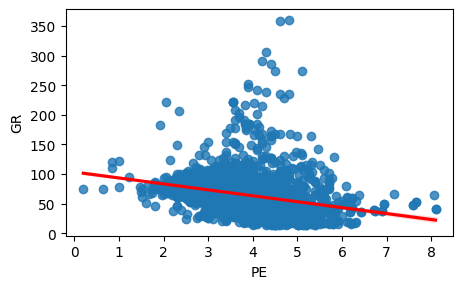

In [24]:
sns.regplot(x='PE',y='GR',data=eda_data, line_kws={'color': 'red'})
plt.show()

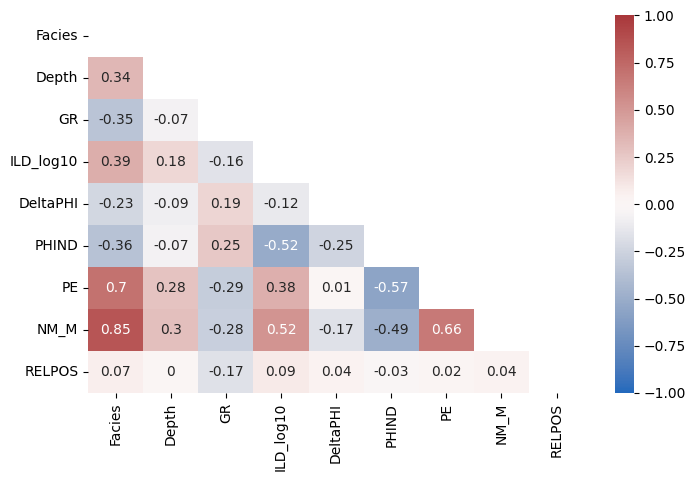

In [25]:
corr_matrix = eda_data.corr().round(2)
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.savefig('images/Correlation_features.png')
plt.show()

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Use this for feature selection plot. Check them out in machinelearning registry

### Correlation among categorical variables

Earlier, we stated that the two categorical columns in the dataset will not be used for modelling based on the nature of the data. Let's use some statistical analysis to confirm that assertion. 

We want to establish that the categorical variables are not highly correlated to the target label and so are useful for model training. Our null hypothes, H0, here is that the variables are not correlated.

In [26]:
print(utils.select_categorical_feature(data, 'Formation', 'Facies'))
print(utils.select_categorical_feature(data, 'Well Name', 'Facies'))

Formation is dependent of Facies, reject H0
Well Name is dependent of Facies, reject H0


The result indicate that both categorical variables are dependent of the target labels. So they are not useful for training a model.

## Conclusion

The results of this analysis show that there are varying degrees of skweness in the different columns of the datset. We will attempt to reduce the skewness before using the variables to train a model. It was established that the categorical variables are not to be used for model training. There are some correlations among some of the numerical variables but in the absence of a good understanding of how these variables are related we will use features importance to identify the most important numerical variables.

Next, we will apply some preprocessing steps to the data and visualization of well log information.